In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import requests
import os
import seaborn as sns
import duckdb

In [3]:
url = 'https://dadosabertos.aneel.gov.br/dataset/da3d8da5-bdc0-471a-b57e-09e49f557c9a/resource/0bf361e5-dc58-4380-95f0-b61a55ec3423/download/sigec-taxa-de-fiscalizacao.csv'
nome_arquivo = '../../dataset/dados.csv'
os.makedirs("../../dataset", exist_ok=True)

def baixa_dataset():
    if os.path.exists(nome_arquivo):
        print("arquivo já existe")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    
    with open(nome_arquivo, 'wb') as file:
        downloaded = 0
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                file.write(chunk)
                downloaded += len(chunk)
                if total_size > 0:
                    percent = (downloaded * 100) / total_size
                    print(f"\rDownload: {percent:.1f}% ({downloaded:,}/{total_size:,} bytes)", end='')
if not os.path.exists(nome_arquivo):
    baixa_dataset()


In [4]:
nome_dataset = 'dados.csv'

df = pd.read_csv(f"../../dataset/{nome_dataset}", delimiter=';', encoding='latin1')
df.head()

,DatGeracaoConjuntoDados,Codcvnarr,AnmArrecadacao,DatVencimentoTitulo,DatIncidenciaMultaMora,DatPagamentoTitulo,QtdDiasEmAtraso,NumCPFCNPJ,SigNomAgente,NomEmpreendimento,NumProcessoSIC,NumAutoInfracao,DscSituacaoArrecadacao,DscSituacaoCredito,VlrPcpPrvArr,VlrTotPvrArr,VlrTotPagArr,VlrTotDifPvrPagArr,VlrSelic
0,2025-11-08,858158,200511.0,2005-12-15,2005-12-16,2005-12-15,0.0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,Taíba,-,-,Quitada pela conciliação automática,Quitada,"3120,38","3120,38","3120,38",",00","2,01874493468739993"
1,2025-11-08,2940945,202010.0,2020-11-16,2020-11-17,2020-11-11,-5.0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,Eólica de Prainha,-,-,Quitada pela conciliação automática,Quitada,"2549,10","2549,10","2549,10",",00",",51130000000000000"
2,2025-11-08,858158,200701.0,2007-02-15,2007-02-16,2007-02-15,0.0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,Eólica de Prainha,-,-,Quitada pela conciliação automática,Quitada,"1205,08","1205,08","1205,08",",00","1,80029697158140180"
3,2025-11-08,2667718,201407.0,2014-08-25,2014-08-26,2014-08-20,-5.0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,Eólica de Prainha,-,-,Quitada pela conciliação automática,Quitada,"1568,77","1568,77","1568,77",",00","1,04650000000000000"
4,2025-11-08,2667718,201412.0,2015-01-15,2015-01-16,2015-01-14,-1.0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,Eólica de Prainha,-,-,Quitada pela conciliação automática,Quitada,"1568,77","1568,77","1568,77",",00","1,00050000000000000"


In [5]:

df['DatGeracaoConjuntoDados'] = pd.to_datetime(df['DatGeracaoConjuntoDados'], errors='coerce')
df['DatVencimentoTitulo']     = pd.to_datetime(df['DatVencimentoTitulo'], errors='coerce')
df['DatIncidenciaMultaMora']  = pd.to_datetime(df['DatIncidenciaMultaMora'], errors='coerce')
df['DatPagamentoTitulo']      = pd.to_datetime(df['DatPagamentoTitulo'], errors='coerce')

df['Codcvnarr']      = pd.to_numeric(df['Codcvnarr'], errors='coerce').astype('Int64')

df['NumCPFCNPJ'] = (
    df['NumCPFCNPJ']
    .astype(str)
    .str.replace(r'\D+', '', regex=True)
    .replace({'', 'nan', 'None'}, np.nan)
)

string_cols = [
    'AnmArrecadacao',
    'SigNomAgente',
    'NomEmpreendimento',
    'NumAutoInfracao',
    'DscSituacaoArrecadacao',
    'DscSituacaoCredito'
]

for col in string_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.strip()
        .replace({'nan': np.nan, 'None': np.nan})
    )

df['QtdDiasEmAtraso'] = (
    pd.to_numeric(df['QtdDiasEmAtraso'], errors='coerce')
      .astype('Int64')
)

def to_float_br(series):
    return (series.astype(str)
                  .str.strip()
                  .str.replace('.', '', regex=False)
                  .str.replace(',', '.', regex=False)
                  .replace(['', 'nan', 'None'], np.nan)
                  .astype(float))

df['VlrPcpPrvArr']      = to_float_br(df['VlrPcpPrvArr'])
df['VlrTotPvrArr']      = to_float_br(df['VlrTotPvrArr'])
df['VlrTotPagArr']      = to_float_br(df['VlrTotPagArr'])
df['VlrTotDifPvrPagArr'] = to_float_br(df['VlrTotDifPvrPagArr'])
df['VlrSelic']          = to_float_br(df['VlrSelic'])

df['VlrPcpPrvArr']       = df['VlrPcpPrvArr'].round(2)
df['VlrTotPvrArr']       = df['VlrTotPvrArr'].round(2)
df['VlrTotPagArr']       = df['VlrTotPagArr'].round(2)
df['VlrTotDifPvrPagArr'] = df['VlrTotDifPvrPagArr'].round(2)
df['VlrSelic']           = df['VlrSelic'].round(2)




In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415207 entries, 0 to 415206
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   DatGeracaoConjuntoDados  415207 non-null  datetime64[ns]
 1   Codcvnarr                415207 non-null  Int64         
 2   AnmArrecadacao           415206 non-null  object        
 3   DatVencimentoTitulo      415207 non-null  datetime64[ns]
 4   DatIncidenciaMultaMora   415207 non-null  datetime64[ns]
 5   DatPagamentoTitulo       405411 non-null  datetime64[ns]
 6   QtdDiasEmAtraso          405411 non-null  Int64         
 7   NumCPFCNPJ               415207 non-null  object        
 8   SigNomAgente             415207 non-null  object        
 9   NomEmpreendimento        360948 non-null  object        
 10  NumProcessoSIC           415207 non-null  object        
 11  NumAutoInfracao          415207 non-null  object        
 12  DscSituacaoArrec

In [7]:
#colunas_numericas = [
#    'VlrPcpPrvArr',
#    'VlrTotPvrArr',
#    'VlrTotPagArr',
#    'VlrTotDifPvrPagArr',
#    'VlrSelic'
#]
#def to_float_br(series):
#    return (
#        series.astype(str)
#              .str.strip()
#              .str.replace('.', '', regex=False)
#              .str.replace(',', '.', regex=False)
#              .replace(['', 'nan', 'None'], np.nan)
#              .astype(float)
#    )
#for col in colunas_numericas:
#    df[col] = to_float_br(df[col])
#df[colunas_numericas].dtypes

In [8]:
#df['QtdDiasEmAtraso'] = (
#    pd.to_numeric(df['QtdDiasEmAtraso'], errors='coerce')
#      .astype('Int64')
#)
#df.isnull().sum()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415207 entries, 0 to 415206
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   DatGeracaoConjuntoDados  415207 non-null  datetime64[ns]
 1   Codcvnarr                415207 non-null  Int64         
 2   AnmArrecadacao           415206 non-null  object        
 3   DatVencimentoTitulo      415207 non-null  datetime64[ns]
 4   DatIncidenciaMultaMora   415207 non-null  datetime64[ns]
 5   DatPagamentoTitulo       405411 non-null  datetime64[ns]
 6   QtdDiasEmAtraso          405411 non-null  Int64         
 7   NumCPFCNPJ               415207 non-null  object        
 8   SigNomAgente             415207 non-null  object        
 9   NomEmpreendimento        360948 non-null  object        
 10  NumProcessoSIC           415207 non-null  object        
 11  NumAutoInfracao          415207 non-null  object        
 12  DscSituacaoArrec

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415207 entries, 0 to 415206
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   DatGeracaoConjuntoDados  415207 non-null  datetime64[ns]
 1   Codcvnarr                415207 non-null  Int64         
 2   AnmArrecadacao           415206 non-null  object        
 3   DatVencimentoTitulo      415207 non-null  datetime64[ns]
 4   DatIncidenciaMultaMora   415207 non-null  datetime64[ns]
 5   DatPagamentoTitulo       405411 non-null  datetime64[ns]
 6   QtdDiasEmAtraso          405411 non-null  Int64         
 7   NumCPFCNPJ               415207 non-null  object        
 8   SigNomAgente             415207 non-null  object        
 9   NomEmpreendimento        360948 non-null  object        
 10  NumProcessoSIC           415207 non-null  object        
 11  NumAutoInfracao          415207 non-null  object        
 12  DscSituacaoArrec

In [11]:
df.drop(columns='NomEmpreendimento', inplace=True)
df.isnull().sum()

DatGeracaoConjuntoDados       0
Codcvnarr                     0
AnmArrecadacao                1
DatVencimentoTitulo           0
DatIncidenciaMultaMora        0
DatPagamentoTitulo         9796
QtdDiasEmAtraso            9796
NumCPFCNPJ                    0
SigNomAgente                  0
NumProcessoSIC                0
NumAutoInfracao               0
DscSituacaoArrecadacao        0
DscSituacaoCredito         7387
VlrPcpPrvArr                  0
VlrTotPvrArr                  3
VlrTotPagArr               9795
VlrTotDifPvrPagArr            0
VlrSelic                      0
dtype: int64

In [12]:
df['DatVencimentoTitulo'] = pd.to_datetime(df['DatVencimentoTitulo'], errors='coerce')
df['DatPagamentoTitulo'] = pd.to_datetime(df['DatPagamentoTitulo'], errors='coerce')

df['DiffDias'] = (df['DatPagamentoTitulo'] - df['DatVencimentoTitulo']).dt.days

#df.loc[df['DatVencimentoTitulo'].isna(), 'QtdDiasEmAtraso'] = 0


df.loc[df['QtdDiasEmAtraso'] < 0, 'QtdDiasEmAtraso'] = 0
df.loc[df['DatPagamentoTitulo'].isna(), 'QtdDiasEmAtraso'] =  pd.NA

mask = (
    df['DiffDias'].notna() &
    (df['DiffDias'] != df['QtdDiasEmAtraso'])
)

df.loc[mask, 'QtdDiasEmAtraso'] = df['DiffDias'].clip(lower=0)
df.drop(columns='DiffDias', inplace=True)

In [13]:
df.isnull().sum()

DatGeracaoConjuntoDados       0
Codcvnarr                     0
AnmArrecadacao                1
DatVencimentoTitulo           0
DatIncidenciaMultaMora        0
DatPagamentoTitulo         9796
QtdDiasEmAtraso            9796
NumCPFCNPJ                    0
SigNomAgente                  0
NumProcessoSIC                0
NumAutoInfracao               0
DscSituacaoArrecadacao        0
DscSituacaoCredito         7387
VlrPcpPrvArr                  0
VlrTotPvrArr                  3
VlrTotPagArr               9795
VlrTotDifPvrPagArr            0
VlrSelic                      0
dtype: int64

In [14]:
df['DscSituacaoCredito'].value_counts()

DscSituacaoCredito
Quitada                                  404936
Inscrição em Dívida Ativa                  1110
Encaminhamento à Procuradoria Federal       558
Execução Judicial                           539
Notificação                                 444
Parcelamento na PRF                         160
CADIN                                        73
Name: count, dtype: int64

In [15]:
cond = df['DscSituacaoCredito'].isna() & df['DatPagamentoTitulo'].isna() & df['VlrTotPagArr'].isna() 
qtde_linhas = cond.sum()
qtde_linhas
print(f"Quantidade de linhas que não tem pagamento e situação de crédito: {qtde_linhas}")

Quantidade de linhas que não tem pagamento e situação de crédito: 6811


In [16]:
cond = df['DscSituacaoCredito'].isna() & df['DatPagamentoTitulo'].isna() 
qtde_linhas = cond.sum()
qtde_linhas
print(f"Quantidade de linhas que não tem pagamento e situação de crédito: {qtde_linhas}")

Quantidade de linhas que não tem pagamento e situação de crédito: 6811


In [17]:
df['DscSituacaoCredito'].unique()

array(['Quitada', nan, 'Inscrição em Dívida Ativa', 'Notificação',
       'CADIN', 'Encaminhamento à Procuradoria Federal',
       'Execução Judicial', 'Parcelamento na PRF'], dtype=object)

In [18]:
df['AnmArrecadacao'] = (
    df['AnmArrecadacao']
    .astype(str)
    .str.replace('.0', '', regex=False)
)

df['AnmArrecadacao'] = pd.to_numeric(df['AnmArrecadacao'], errors='coerce').astype('Int64')

df['AnoArrec'] = df['AnmArrecadacao'] // 100
df['MesArrec'] = df['AnmArrecadacao'] % 100

df['AnmArrecadacao'] = df['AnoArrec'].astype(str) + "-" + df['MesArrec'].astype(str).str.zfill(2)

In [19]:
#df['VlrTotPvrArr'] = df['VlrTotPvrArr'].str.replace(',', '.').astype(float)
#df['VlrTotDifPvrPagArr'] = df['VlrTotDifPvrPagArr'].str.replace(',', '.').astype(float)
df['VlrTotPagArr_Corregido'] = df['VlrTotDifPvrPagArr']  - df['VlrTotPvrArr']
mask = df['VlrTotPagArr'].isna()

df.loc[mask, 'VlrTotPagArr'] = df.loc[mask, 'VlrTotPagArr_Corregido']
df.drop(columns='VlrTotPagArr_Corregido', inplace=True)

In [20]:
df.loc[df['VlrTotPagArr'] < 0, 'VlrTotPagArr'] *= -1


In [21]:
df[df['VlrTotPagArr'] < 0]

,DatGeracaoConjuntoDados,Codcvnarr,AnmArrecadacao,DatVencimentoTitulo,DatIncidenciaMultaMora,DatPagamentoTitulo,QtdDiasEmAtraso,NumCPFCNPJ,SigNomAgente,NumProcessoSIC,NumAutoInfracao,DscSituacaoArrecadacao,DscSituacaoCredito,VlrPcpPrvArr,VlrTotPvrArr,VlrTotPagArr,VlrTotDifPvrPagArr,VlrSelic,AnoArrec,MesArrec


In [22]:
mapeamento = {
    'Quitada pela conciliação automática': 'quitada',
    'Quitação manual': 'quitada',
    'Quitada por diferença de meses anteriores': 'quitada',
    'Pendente de quitação': 'pendente',
    'Cancelada': 'cancelada',
    'Restituída': 'restituida'
}

df['DscSituacaoArrecadacao'] = df['DscSituacaoArrecadacao'].replace(mapeamento)


In [23]:
mask = (
    df['DscSituacaoCredito'].isna() &
    df['DatPagamentoTitulo'].isna()
)

df.loc[mask, 'DscSituacaoCredito'] = 'Inscrição em Dívida Ativa'

In [24]:
df.isnull().sum()

DatGeracaoConjuntoDados       0
Codcvnarr                     0
AnmArrecadacao                0
DatVencimentoTitulo           0
DatIncidenciaMultaMora        0
DatPagamentoTitulo         9796
QtdDiasEmAtraso            9796
NumCPFCNPJ                    0
SigNomAgente                  0
NumProcessoSIC                0
NumAutoInfracao               0
DscSituacaoArrecadacao        0
DscSituacaoCredito          576
VlrPcpPrvArr                  0
VlrTotPvrArr                  3
VlrTotPagArr                  3
VlrTotDifPvrPagArr            0
VlrSelic                      0
AnoArrec                      1
MesArrec                      1
dtype: int64

In [25]:
cond = df['DatPagamentoTitulo'].notna() & df['VlrTotPagArr'].isna()
qtde_linhas = cond.sum()
qtde_linhas

np.int64(0)

In [26]:
df['fatura_paga'] = df['DatPagamentoTitulo'].notna().astype(int)
df['fatura_atrasado'] = (df['QtdDiasEmAtraso'] > 0).notna().astype(int)
df['fatura_nao_paga'] = df['DatPagamentoTitulo'].isna().astype(int)


In [27]:
df.isnull().sum() 

DatGeracaoConjuntoDados       0
Codcvnarr                     0
AnmArrecadacao                0
DatVencimentoTitulo           0
DatIncidenciaMultaMora        0
DatPagamentoTitulo         9796
QtdDiasEmAtraso            9796
NumCPFCNPJ                    0
SigNomAgente                  0
NumProcessoSIC                0
NumAutoInfracao               0
DscSituacaoArrecadacao        0
DscSituacaoCredito          576
VlrPcpPrvArr                  0
VlrTotPvrArr                  3
VlrTotPagArr                  3
VlrTotDifPvrPagArr            0
VlrSelic                      0
AnoArrec                      1
MesArrec                      1
fatura_paga                   0
fatura_atrasado               0
fatura_nao_paga               0
dtype: int64

In [28]:
cond = df['DscSituacaoCredito'].isna() & df['QtdDiasEmAtraso'] > 0
qtde_linhas = cond.sum()
qtde_linhas

np.int64(120)

In [29]:
mask = (
    df['DscSituacaoCredito'].isna() &
    df['QtdDiasEmAtraso'] > 0
)

df.loc[mask, 'DscSituacaoCredito'] = 'Inscrição em Dívida Ativa'

In [30]:
df.isnull().sum()

DatGeracaoConjuntoDados       0
Codcvnarr                     0
AnmArrecadacao                0
DatVencimentoTitulo           0
DatIncidenciaMultaMora        0
DatPagamentoTitulo         9796
QtdDiasEmAtraso            9796
NumCPFCNPJ                    0
SigNomAgente                  0
NumProcessoSIC                0
NumAutoInfracao               0
DscSituacaoArrecadacao        0
DscSituacaoCredito          456
VlrPcpPrvArr                  0
VlrTotPvrArr                  3
VlrTotPagArr                  3
VlrTotDifPvrPagArr            0
VlrSelic                      0
AnoArrec                      1
MesArrec                      1
fatura_paga                   0
fatura_atrasado               0
fatura_nao_paga               0
dtype: int64

In [31]:
cond = (df['DscSituacaoCredito'].isna()) & (df['QtdDiasEmAtraso'] == 0) & (df['DatPagamentoTitulo'].notna())  
qtde_linhas = cond.sum()
qtde_linhas

np.int64(292)

In [32]:
cond = (df['DscSituacaoCredito'].isna()) & (df['QtdDiasEmAtraso'] == 0) & (df['DatPagamentoTitulo'].notna())  
df.loc[cond, 'DscSituacaoCredito'] = 'Quitada'

In [33]:
df.isnull().sum()

DatGeracaoConjuntoDados       0
Codcvnarr                     0
AnmArrecadacao                0
DatVencimentoTitulo           0
DatIncidenciaMultaMora        0
DatPagamentoTitulo         9796
QtdDiasEmAtraso            9796
NumCPFCNPJ                    0
SigNomAgente                  0
NumProcessoSIC                0
NumAutoInfracao               0
DscSituacaoArrecadacao        0
DscSituacaoCredito          164
VlrPcpPrvArr                  0
VlrTotPvrArr                  3
VlrTotPagArr                  3
VlrTotDifPvrPagArr            0
VlrSelic                      0
AnoArrec                      1
MesArrec                      1
fatura_paga                   0
fatura_atrasado               0
fatura_nao_paga               0
dtype: int64

In [34]:
cond = (df['DscSituacaoCredito'].isna()) & (df['QtdDiasEmAtraso'] > 0 & (df['VlrTotPagArr'] >= df['VlrTotPvrArr']))  
qtde_linhas = cond.sum()
qtde_linhas

np.int64(164)

In [35]:
cond = (df['DscSituacaoCredito'].isna()) & (df['QtdDiasEmAtraso'] > 0 & (df['VlrTotPagArr'] >= df['VlrTotPvrArr']))  
df.loc[cond, 'DscSituacaoCredito'] = 'Quitada'

In [36]:
df.isnull().sum()

DatGeracaoConjuntoDados       0
Codcvnarr                     0
AnmArrecadacao                0
DatVencimentoTitulo           0
DatIncidenciaMultaMora        0
DatPagamentoTitulo         9796
QtdDiasEmAtraso            9796
NumCPFCNPJ                    0
SigNomAgente                  0
NumProcessoSIC                0
NumAutoInfracao               0
DscSituacaoArrecadacao        0
DscSituacaoCredito            0
VlrPcpPrvArr                  0
VlrTotPvrArr                  3
VlrTotPagArr                  3
VlrTotDifPvrPagArr            0
VlrSelic                      0
AnoArrec                      1
MesArrec                      1
fatura_paga                   0
fatura_atrasado               0
fatura_nao_paga               0
dtype: int64

In [37]:
df.drop(columns=['DatPagamentoTitulo'], inplace=True)

In [38]:
df['QtdDiasEmAtraso'] = df['QtdDiasEmAtraso'].fillna(-1).astype(int)

In [39]:
df.isnull().sum()

DatGeracaoConjuntoDados    0
Codcvnarr                  0
AnmArrecadacao             0
DatVencimentoTitulo        0
DatIncidenciaMultaMora     0
QtdDiasEmAtraso            0
NumCPFCNPJ                 0
SigNomAgente               0
NumProcessoSIC             0
NumAutoInfracao            0
DscSituacaoArrecadacao     0
DscSituacaoCredito         0
VlrPcpPrvArr               0
VlrTotPvrArr               3
VlrTotPagArr               3
VlrTotDifPvrPagArr         0
VlrSelic                   0
AnoArrec                   1
MesArrec                   1
fatura_paga                0
fatura_atrasado            0
fatura_nao_paga            0
dtype: int64

In [40]:
df.head()


,DatGeracaoConjuntoDados,Codcvnarr,AnmArrecadacao,DatVencimentoTitulo,DatIncidenciaMultaMora,QtdDiasEmAtraso,NumCPFCNPJ,SigNomAgente,NumProcessoSIC,NumAutoInfracao,...,VlrPcpPrvArr,VlrTotPvrArr,VlrTotPagArr,VlrTotDifPvrPagArr,VlrSelic,AnoArrec,MesArrec,fatura_paga,fatura_atrasado,fatura_nao_paga
0,2025-11-08,858158,2005-11,2005-12-15,2005-12-16,0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,-,-,...,3120.38,3120.38,3120.38,0.0,2.02,2005,11,1,1,0
1,2025-11-08,2940945,2020-10,2020-11-16,2020-11-17,0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,-,-,...,2549.10,2549.10,2549.10,0.0,0.51,2020,10,1,1,0
2,2025-11-08,858158,2007-01,2007-02-15,2007-02-16,0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,-,-,...,1205.08,1205.08,1205.08,0.0,1.80,2007,1,1,1,0
3,2025-11-08,2667718,2014-07,2014-08-25,2014-08-26,0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,-,-,...,1568.77,1568.77,1568.77,0.0,1.05,2014,7,1,1,0
4,2025-11-08,2667718,2014-12,2015-01-15,2015-01-16,0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,-,-,...,1568.77,1568.77,1568.77,0.0,1.00,2014,12,1,1,0


In [41]:
quantidade_ausente_NumProcessoSIC = df[df['NumProcessoSIC'] == ' - ']['NumProcessoSIC'].count()

quantidade_ausente_NumAutoInfracao = df[df['NumAutoInfracao'] == '-']['NumAutoInfracao'].count()

print(f"A porcentagem de valores ausentes na coluna 'NumProcessoSIC' é de {(quantidade_ausente_NumProcessoSIC / len(df)) * 100:.2f}%")
print(f"A porcentagem de valores ausentes na coluna 'NumAutoInfracao' é de {(quantidade_ausente_NumAutoInfracao / len(df)) * 100:.2f}%")

A porcentagem de valores ausentes na coluna 'NumProcessoSIC' é de 99.14%
A porcentagem de valores ausentes na coluna 'NumAutoInfracao' é de 100.00%


In [42]:
df_nulos = df[df.isna().any(axis=1)]
df_nulos

,DatGeracaoConjuntoDados,Codcvnarr,AnmArrecadacao,DatVencimentoTitulo,DatIncidenciaMultaMora,QtdDiasEmAtraso,NumCPFCNPJ,SigNomAgente,NumProcessoSIC,NumAutoInfracao,...,VlrPcpPrvArr,VlrTotPvrArr,VlrTotPagArr,VlrTotDifPvrPagArr,VlrSelic,AnoArrec,MesArrec,fatura_paga,fatura_atrasado,fatura_nao_paga
152339,2025-11-08,858158,2011-12,2012-01-16,2012-01-17,-1,5345447000116,PIEDADE PIEDADE USINA GERADORA DE...,-,-,...,4562.68,NaN,NaN,0.0,1.27,2011,12,0,0,1
215548,2025-11-08,858158,2014-07,2014-08-25,2014-08-26,-1,5751762000143,CEISA - CENTRAL ENERGETICA ITAUNAS S/A,-,-,...,862.82,NaN,NaN,0.0,1.05,2014,7,0,0,1
215574,2025-11-08,858158,2014-06,2014-07-15,2014-07-16,-1,5751762000143,CEISA - CENTRAL ENERGETICA ITAUNAS S/A,-,-,...,862.82,NaN,NaN,0.0,1.06,2014,6,0,0,1
228383,2025-11-08,858158,<NA>-<NA>,2010-06-23,2010-06-24,84,7386098000106,RAESA RIO AMAZONAS ENERGIA S/A,-,-,...,231.54,284.22,284.22,0.0,1.44,<NA>,<NA>,1,1,0


Como a quantidade de registros com valores ausentes são apenas quatro linhas, decidimos então remover estes registros.

In [43]:
df.drop(columns=['NumProcessoSIC', 'NumAutoInfracao'], inplace=True)

In [44]:
df.dropna(inplace=True)

In [45]:
df.isnull().sum()

DatGeracaoConjuntoDados    0
Codcvnarr                  0
AnmArrecadacao             0
DatVencimentoTitulo        0
DatIncidenciaMultaMora     0
QtdDiasEmAtraso            0
NumCPFCNPJ                 0
SigNomAgente               0
DscSituacaoArrecadacao     0
DscSituacaoCredito         0
VlrPcpPrvArr               0
VlrTotPvrArr               0
VlrTotPagArr               0
VlrTotDifPvrPagArr         0
VlrSelic                   0
AnoArrec                   0
MesArrec                   0
fatura_paga                0
fatura_atrasado            0
fatura_nao_paga            0
dtype: int64

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 415203 entries, 0 to 415206
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   DatGeracaoConjuntoDados  415203 non-null  datetime64[ns]
 1   Codcvnarr                415203 non-null  Int64         
 2   AnmArrecadacao           415203 non-null  object        
 3   DatVencimentoTitulo      415203 non-null  datetime64[ns]
 4   DatIncidenciaMultaMora   415203 non-null  datetime64[ns]
 5   QtdDiasEmAtraso          415203 non-null  int64         
 6   NumCPFCNPJ               415203 non-null  object        
 7   SigNomAgente             415203 non-null  object        
 8   DscSituacaoArrecadacao   415203 non-null  object        
 9   DscSituacaoCredito       415203 non-null  object        
 10  VlrPcpPrvArr             415203 non-null  float64       
 11  VlrTotPvrArr             415203 non-null  float64       
 12  VlrTotPagArr         

In [47]:
df.head()

,DatGeracaoConjuntoDados,Codcvnarr,AnmArrecadacao,DatVencimentoTitulo,DatIncidenciaMultaMora,QtdDiasEmAtraso,NumCPFCNPJ,SigNomAgente,DscSituacaoArrecadacao,DscSituacaoCredito,VlrPcpPrvArr,VlrTotPvrArr,VlrTotPagArr,VlrTotDifPvrPagArr,VlrSelic,AnoArrec,MesArrec,fatura_paga,fatura_atrasado,fatura_nao_paga
0,2025-11-08,858158,2005-11,2005-12-15,2005-12-16,0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,quitada,Quitada,3120.38,3120.38,3120.38,0.0,2.02,2005,11,1,1,0
1,2025-11-08,2940945,2020-10,2020-11-16,2020-11-17,0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,quitada,Quitada,2549.10,2549.10,2549.10,0.0,0.51,2020,10,1,1,0
2,2025-11-08,858158,2007-01,2007-02-15,2007-02-16,0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,quitada,Quitada,1205.08,1205.08,1205.08,0.0,1.80,2007,1,1,1,0
3,2025-11-08,2667718,2014-07,2014-08-25,2014-08-26,0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,quitada,Quitada,1568.77,1568.77,1568.77,0.0,1.05,2014,7,1,1,0
4,2025-11-08,2667718,2014-12,2015-01-15,2015-01-16,0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,quitada,Quitada,1568.77,1568.77,1568.77,0.0,1.00,2014,12,1,1,0


In [48]:
df['TrimestreVencimento'] = df['DatVencimentoTitulo'].dt.quarter.map({
    1: '1',
    2: '2',
    3: '3',
    4: '4'
})

In [49]:
df

,DatGeracaoConjuntoDados,Codcvnarr,AnmArrecadacao,DatVencimentoTitulo,DatIncidenciaMultaMora,QtdDiasEmAtraso,NumCPFCNPJ,SigNomAgente,DscSituacaoArrecadacao,DscSituacaoCredito,...,VlrTotPvrArr,VlrTotPagArr,VlrTotDifPvrPagArr,VlrSelic,AnoArrec,MesArrec,fatura_paga,fatura_atrasado,fatura_nao_paga,TrimestreVencimento
0,2025-11-08,858158,2005-11,2005-12-15,2005-12-16,0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,quitada,Quitada,...,3120.38,3120.38,0.00,2.02,2005,11,1,1,0,4
1,2025-11-08,2940945,2020-10,2020-11-16,2020-11-17,0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,quitada,Quitada,...,2549.10,2549.10,0.00,0.51,2020,10,1,1,0,4
2,2025-11-08,858158,2007-01,2007-02-15,2007-02-16,0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,quitada,Quitada,...,1205.08,1205.08,0.00,1.80,2007,1,1,1,0,1
3,2025-11-08,2667718,2014-07,2014-08-25,2014-08-26,0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,quitada,Quitada,...,1568.77,1568.77,0.00,1.05,2014,7,1,1,0,3
4,2025-11-08,2667718,2014-12,2015-01-15,2015-01-16,0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,quitada,Quitada,...,1568.77,1568.77,0.00,1.00,2014,12,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415202,2025-11-08,2940945,2017-08,2017-09-15,2017-09-16,0,16617789000164,AGROPEU-AGRO INDUSTRIAL DE POMPEU S/A,quitada,Quitada,...,5235.61,5235.61,0.00,0.67,2017,8,1,1,0,3
415203,2025-11-08,2940945,2017-05,2017-06-16,2017-06-17,0,16617789000164,AGROPEU-AGRO INDUSTRIAL DE POMPEU S/A,quitada,Quitada,...,5235.61,5235.61,0.00,0.70,2017,5,1,1,0,2
415204,2025-11-08,2940945,2017-07,2017-08-15,2017-08-16,1,16617789000164,AGROPEU-AGRO INDUSTRIAL DE POMPEU S/A,quitada,Quitada,...,5252.89,5235.61,17.28,0.68,2017,7,1,1,0,3
415205,2025-11-08,2940945,2017-07,2017-08-17,2017-08-18,60,16617789000164,AGROPEU-AGRO INDUSTRIAL DE POMPEU S/A,quitada,Quitada,...,17.56,17.56,0.00,0.68,2017,7,1,1,0,3


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 415203 entries, 0 to 415206
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   DatGeracaoConjuntoDados  415203 non-null  datetime64[ns]
 1   Codcvnarr                415203 non-null  Int64         
 2   AnmArrecadacao           415203 non-null  object        
 3   DatVencimentoTitulo      415203 non-null  datetime64[ns]
 4   DatIncidenciaMultaMora   415203 non-null  datetime64[ns]
 5   QtdDiasEmAtraso          415203 non-null  int64         
 6   NumCPFCNPJ               415203 non-null  object        
 7   SigNomAgente             415203 non-null  object        
 8   DscSituacaoArrecadacao   415203 non-null  object        
 9   DscSituacaoCredito       415203 non-null  object        
 10  VlrPcpPrvArr             415203 non-null  float64       
 11  VlrTotPvrArr             415203 non-null  float64       
 12  VlrTotPagArr         

In [51]:
def calcula_metricas(dados, nome_coluna):
    media = dados.mean()
    mediana = dados.median()
    desvio_padrao = dados.std()
    minimo = dados.min()
    maximo = dados.max()
    print(f"Métricas para a coluna: {nome_coluna}")
    print(f"Média: {media}")
    print(f"Mediana: {mediana}")
    print(f"Desvio Padrão: {desvio_padrao}")
    print(f"Mínimo: {minimo}")
    print(f"Máximo: {maximo}")


In [52]:
#colunas = ['QtdDiasEmAtraso', 'VlrPcpPrvArr', 'VlrTotPvrArr', 'VlrTotPagArr', 'VlrTotDifPvrPagArr', 'VlrSelic']
coluna = 'QtdDiasEmAtraso'
calcula_metricas(df[coluna], coluna)

Métricas para a coluna: QtdDiasEmAtraso
Média: 6.849285771056567
Mediana: 0.0
Desvio Padrão: 90.42438966974804
Mínimo: -1
Máximo: 5389


In [53]:
len(df)

415203

In [54]:
bins = range(0, df['QtdDiasEmAtraso'].max() + 100, 100)
df_faixa = pd.DataFrame()

df_faixa['faixa'] = pd.cut(
    df['QtdDiasEmAtraso'],
    bins=bins,
    right=True,
    include_lowest=True
)

df_faixa['faixa'].value_counts().sort_index()

faixa
(-0.001, 100.0]     401019
(100.0, 200.0]        1864
(200.0, 300.0]         763
(300.0, 400.0]         497
(400.0, 500.0]         289
(500.0, 600.0]         152
(600.0, 700.0]         105
(700.0, 800.0]          85
(800.0, 900.0]          78
(900.0, 1000.0]         55
(1000.0, 1100.0]        31
(1100.0, 1200.0]        32
(1200.0, 1300.0]        33
(1300.0, 1400.0]        27
(1400.0, 1500.0]        25
(1500.0, 1600.0]        25
(1600.0, 1700.0]        15
(1700.0, 1800.0]        15
(1800.0, 1900.0]        19
(1900.0, 2000.0]        24
(2000.0, 2100.0]        15
(2100.0, 2200.0]        15
(2200.0, 2300.0]        16
(2300.0, 2400.0]        29
(2400.0, 2500.0]        22
(2500.0, 2600.0]        20
(2600.0, 2700.0]        19
(2700.0, 2800.0]        10
(2800.0, 2900.0]         4
(2900.0, 3000.0]         4
(3000.0, 3100.0]         3
(3100.0, 3200.0]         4
(3200.0, 3300.0]         5
(3300.0, 3400.0]         7
(3400.0, 3500.0]         9
(3500.0, 3600.0]        12
(3600.0, 3700.0]      

In [55]:
qt_atraso = df[df['QtdDiasEmAtraso'] > 1000]['QtdDiasEmAtraso'].count()
print(f"Quantidade de faturas com mais de 1000 dias em atraso: {qt_atraso}")

Quantidade de faturas com mais de 1000 dias em atraso: 503


In [56]:
qt_atraso = df[df['QtdDiasEmAtraso'] > 500]['QtdDiasEmAtraso'].count()
print(f"Quantidade de faturas com mais de 500 dias em atraso: {qt_atraso}")

Quantidade de faturas com mais de 500 dias em atraso: 978


In [57]:
qt_atraso = df[df['QtdDiasEmAtraso'] > 365]['QtdDiasEmAtraso'].count()
print(f"Quantidade de faturas com mais de 365 dias em atraso: {qt_atraso}")

Quantidade de faturas com mais de 365 dias em atraso: 1403


In [58]:
LIMITE = 1000

df['QtdDiasEmAtraso'] = df['QtdDiasEmAtraso'].clip(upper=LIMITE)

In [59]:
bins = range(0, df['QtdDiasEmAtraso'].max() + 100, 100)
df_faixa = pd.DataFrame()

df_faixa['faixa'] = pd.cut(
    df['QtdDiasEmAtraso'],
    bins=bins,
    right=True,
    include_lowest=True
)

df_faixa['faixa'].value_counts().sort_index()

faixa
(-0.001, 100.0]    401019
(100.0, 200.0]       1864
(200.0, 300.0]        763
(300.0, 400.0]        497
(400.0, 500.0]        289
(500.0, 600.0]        152
(600.0, 700.0]        105
(700.0, 800.0]         85
(800.0, 900.0]         78
(900.0, 1000.0]       558
Name: count, dtype: int64

In [60]:
#colunas = ['QtdDiasEmAtraso', 'VlrPcpPrvArr', 'VlrTotPvrArr', 'VlrTotPagArr', 'VlrTotDifPvrPagArr', 'VlrSelic']
coluna = 'VlrPcpPrvArr'
calcula_metricas(df[coluna], coluna)

Métricas para a coluna: VlrPcpPrvArr
Média: 32263.696954742616
Mediana: 6390.6
Desvio Padrão: 138765.68327916166
Mínimo: 0.0
Máximo: 4079708.62


In [61]:
#colunas = ['QtdDiasEmAtraso', 'VlrPcpPrvArr', 'VlrTotPvrArr', 'VlrTotPagArr', 'VlrTotDifPvrPagArr', 'VlrSelic']
coluna = 'VlrTotPvrArr'
calcula_metricas(df[coluna], coluna)

Métricas para a coluna: VlrTotPvrArr
Média: 32389.08468811643
Mediana: 6391.45
Desvio Padrão: 140447.8936511949
Mínimo: 0.0
Máximo: 11741802.59


In [62]:
#colunas = ['QtdDiasEmAtraso', 'VlrPcpPrvArr', 'VlrTotPvrArr', 'VlrTotPagArr', 'VlrTotDifPvrPagArr', 'VlrSelic']
coluna = 'VlrTotPagArr'
calcula_metricas(df[coluna], coluna)

Métricas para a coluna: VlrTotPagArr
Média: 31935.000715433158
Mediana: 6311.49
Desvio Padrão: 138011.38723589928
Mínimo: 0.0
Máximo: 4342913.71


In [63]:
#colunas = ['QtdDiasEmAtraso', 'VlrPcpPrvArr', 'VlrTotPvrArr', 'VlrTotPagArr', 'VlrTotDifPvrPagArr', 'VlrSelic']
coluna = 'VlrTotDifPvrPagArr'
calcula_metricas(df[coluna], coluna)

Métricas para a coluna: VlrTotDifPvrPagArr
Média: 454.0841182024215
Mediana: 0.0
Desvio Padrão: 26574.54204543687
Mínimo: -97751.72
Máximo: 11729422.35


In [64]:
#colunas = ['QtdDiasEmAtraso', 'VlrPcpPrvArr', 'VlrTotPvrArr', 'VlrTotPagArr', 'VlrTotDifPvrPagArr', 'VlrSelic']
coluna = 'VlrSelic'
calcula_metricas(df[coluna], coluna)

Métricas para a coluna: VlrSelic
Média: 0.7068813809148777
Mediana: 0.56
Desvio Padrão: 0.5086310592804908
Mínimo: 0.0
Máximo: 2.25


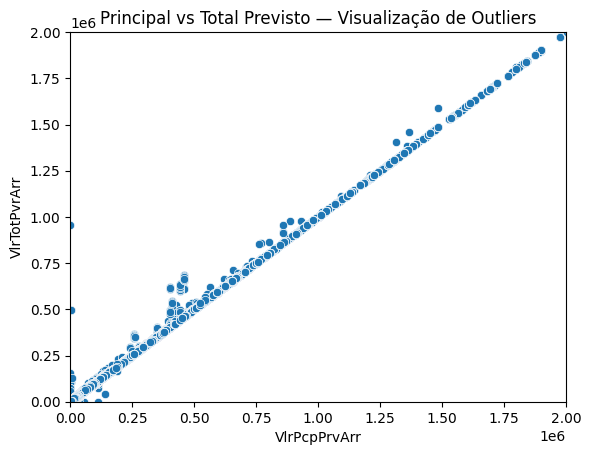

In [89]:
sns.scatterplot(data=df, x='VlrPcpPrvArr', y='VlrTotPvrArr')
plt.xlim(0, 2000000)
plt.ylim(0, 2000000)
plt.title("Principal vs Total Previsto — Visualização de Outliers")
plt.show()


In [66]:
df['perc_excesso'] = (df['VlrTotPagArr'] - df['VlrTotPvrArr']) / df['VlrTotPvrArr']

df_pos = df[df['perc_excesso'] >= 0].copy()

bins = np.arange(0, 1.1, 0.1)  
bins = np.append(bins, [np.inf])

df_pos['faixa_percentual'] = pd.cut(
    df_pos['perc_excesso'],
    bins=bins,
    labels=[
        "0–10%", "10–20%", "20–30%", "30–40%", "40–50%",
        "50–60%", "60–70%", "70–80%", "80–90%", "90–100%",
        ">100%"
    ],
    include_lowest=True
)

contagem = df_pos['faixa_percentual'].value_counts().sort_index()
df.drop(columns='perc_excesso', inplace=True)
contagem

faixa_percentual
0–10%      401597
10–20%         77
20–30%         15
30–40%         20
40–50%         24
50–60%          6
60–70%          2
70–80%          0
80–90%          0
90–100%         5
>100%          39
Name: count, dtype: int64

In [67]:
df['perc_excesso'] = (df['VlrTotPagArr'] - df['VlrTotPvrArr']) / df['VlrTotPvrArr']

mask_outlier = df['perc_excesso'] > 0.15

df.loc[mask_outlier, 'VlrTotPagArr'] = df.loc[mask_outlier, 'VlrTotPvrArr'] * 1.15


df['VlrTotDifPvrPagArr'] =  df['VlrTotPagArr'] - df['VlrTotPvrArr']

df.drop(columns='perc_excesso', inplace=True)

In [68]:
df['perc_excesso'] = (df['VlrTotPagArr'] - df['VlrTotPvrArr']) / df['VlrTotPvrArr']
df_pos = df[df['perc_excesso'] >= 0].copy()
bins = np.arange(0, 1.1, 0.1)  
bins = np.append(bins, [np.inf])
df_pos['faixa_percentual'] = pd.cut(
    df_pos['perc_excesso'],
    bins=bins,
    labels=[
        "0–10%", "10–20%", "20–30%", "30–40%", "40–50%",
        "50–60%", "60–70%", "70–80%", "80–90%", "90–100%",
        ">100%"
    ],
    include_lowest=True
)
contagem = df_pos['faixa_percentual'].value_counts().sort_index()
df.drop(columns='perc_excesso', inplace=True)
contagem


faixa_percentual
0–10%      401597
10–20%        166
20–30%          0
30–40%          0
40–50%          0
50–60%          0
60–70%          0
70–80%          0
80–90%          0
90–100%         0
>100%           0
Name: count, dtype: int64

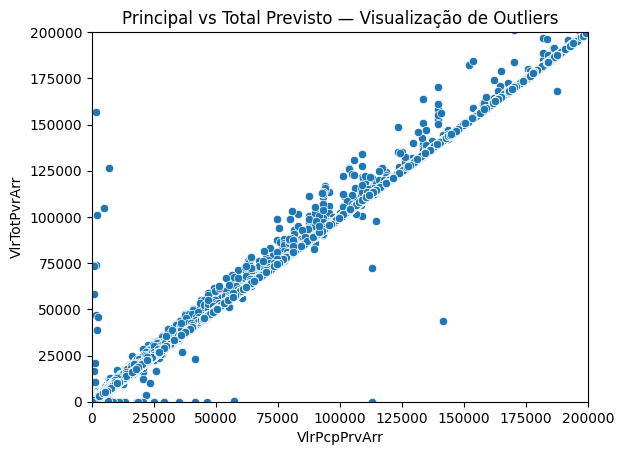

In [69]:
sns.scatterplot(data=df, x='VlrPcpPrvArr', y='VlrTotPvrArr')
plt.xlim(0, 200000)
plt.ylim(0, 200000)
plt.title("Principal vs Total Previsto — Visualização de Outliers")
plt.show()


In [70]:
mapping_credito_simplificado = {
    'Quitada': 'quitada',
    'Notificação': 'pendente',
    'CADIN': 'pendente',
    'Parcelamento na PRF': 'pendente',
    'Inscrição em Dívida Ativa': 'pendente',
    'Encaminhamento à Procuradoria Federal': 'pendente',
    'Execução Judicial': 'pendente'
}

df['DscSituacaoCredito'] = (
    df['DscSituacaoCredito']
      .str.strip()
      .replace(mapping_credito_simplificado)
      .str.lower()
)


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 415203 entries, 0 to 415206
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   DatGeracaoConjuntoDados  415203 non-null  datetime64[ns]
 1   Codcvnarr                415203 non-null  Int64         
 2   AnmArrecadacao           415203 non-null  object        
 3   DatVencimentoTitulo      415203 non-null  datetime64[ns]
 4   DatIncidenciaMultaMora   415203 non-null  datetime64[ns]
 5   QtdDiasEmAtraso          415203 non-null  int64         
 6   NumCPFCNPJ               415203 non-null  object        
 7   SigNomAgente             415203 non-null  object        
 8   DscSituacaoArrecadacao   415203 non-null  object        
 9   DscSituacaoCredito       415203 non-null  object        
 10  VlrPcpPrvArr             415203 non-null  float64       
 11  VlrTotPvrArr             415203 non-null  float64       
 12  VlrTotPagArr         

In [72]:
df.head()

,DatGeracaoConjuntoDados,Codcvnarr,AnmArrecadacao,DatVencimentoTitulo,DatIncidenciaMultaMora,QtdDiasEmAtraso,NumCPFCNPJ,SigNomAgente,DscSituacaoArrecadacao,DscSituacaoCredito,...,VlrTotPvrArr,VlrTotPagArr,VlrTotDifPvrPagArr,VlrSelic,AnoArrec,MesArrec,fatura_paga,fatura_atrasado,fatura_nao_paga,TrimestreVencimento
0,2025-11-08,858158,2005-11,2005-12-15,2005-12-16,0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,quitada,quitada,...,3120.38,3120.38,0.0,2.02,2005,11,1,1,0,4
1,2025-11-08,2940945,2020-10,2020-11-16,2020-11-17,0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,quitada,quitada,...,2549.10,2549.10,0.0,0.51,2020,10,1,1,0,4
2,2025-11-08,858158,2007-01,2007-02-15,2007-02-16,0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,quitada,quitada,...,1205.08,1205.08,0.0,1.80,2007,1,1,1,0,1
3,2025-11-08,2667718,2014-07,2014-08-25,2014-08-26,0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,quitada,quitada,...,1568.77,1568.77,0.0,1.05,2014,7,1,1,0,3
4,2025-11-08,2667718,2014-12,2015-01-15,2015-01-16,0,1027335000166,WOBBEN WINDPOWER INDUSTRIA E COMERCIO LTDA,quitada,quitada,...,1568.77,1568.77,0.0,1.00,2014,12,1,1,0,1


## Conectando ao DuckDb

In [110]:
con = duckdb.connect() 

df_sql = df.copy()

con.register("df_table", df_sql)
